In [1]:
import seaborn as sns
import json
import numpy as np

from bounds.bound_utils import Error
from expe_lib import unpickle_bound, PROBLEMS, load_result_and_bounds, compute_errors

NB_POINTS = 1000

try:
    snakemake.input
except:
    snakemake = type('', (), {})()
    snakemake.input = [
        "output/bounds/lb/lagrangian_quadratic/microgrid/2.json",
        "output/bounds/ub/lagrangian_quadratic/microgrid/6.json",
        "output/bounds/lb/robust_concave_envelope/microgrid/2.json",
        "output/bounds/lb/robust_concave_envelope/microgrid/6.json",
        "output/bounds/ub/robust_concave_envelope/microgrid/6.json",
        "output/bounds/ub/robust_flat/microgrid/6.json",
    ]
    truth_file = "output/truth/microgrid/100.npz"

(949004,)
(2025829, 1)


In [2]:
def not_dominated_points(coord_x, coord_y, label):
    not_dominated_x = []
    not_dominated_y = []
    not_dominated_label = []
    for x_i, y_i,label_i in zip(coord_x, coord_y, label):
        dominated = False
        for x_j, y_j in zip(coord_x, coord_y):
            if (x_i > x_j and y_i > y_j):
                dominated = True
                break
        if not dominated: 
            not_dominated_x.append(x_i)
            not_dominated_y.append(y_i)
            not_dominated_label.append(label_i)
    return not_dominated_x, not_dominated_y, not_dominated_label

/Users/bmiftari/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/bmiftari/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


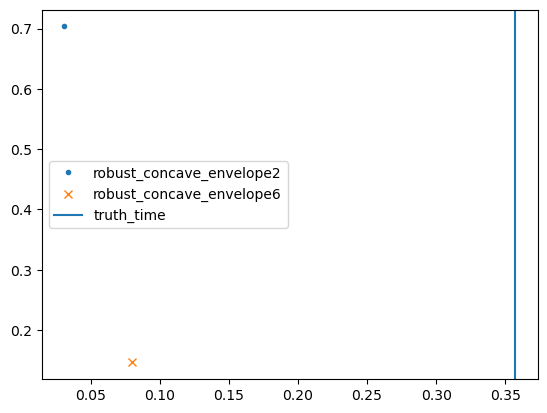

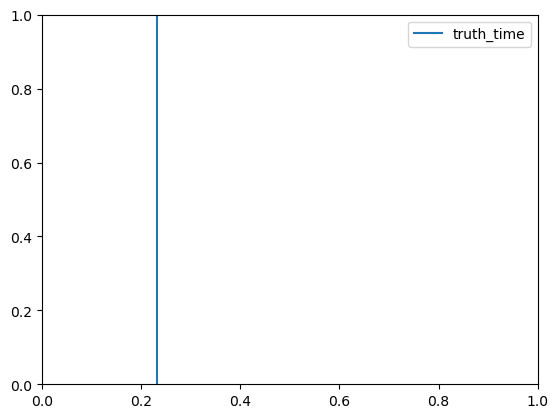

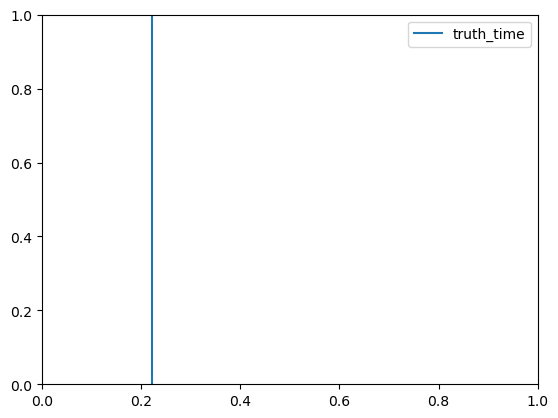

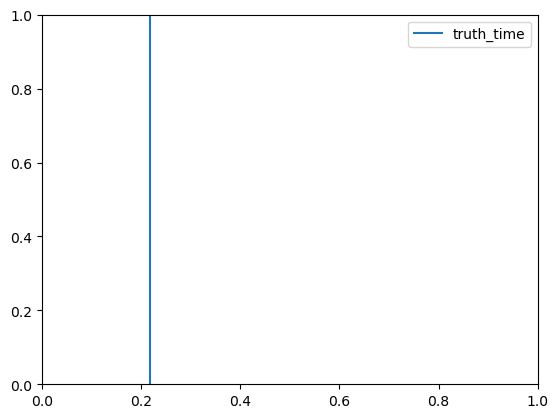

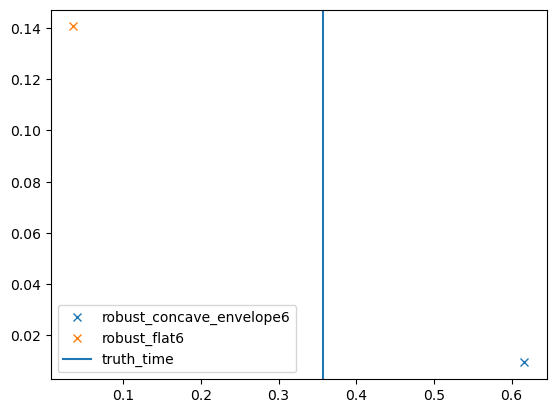

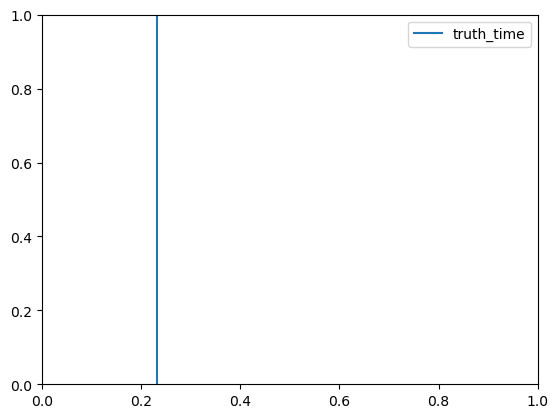

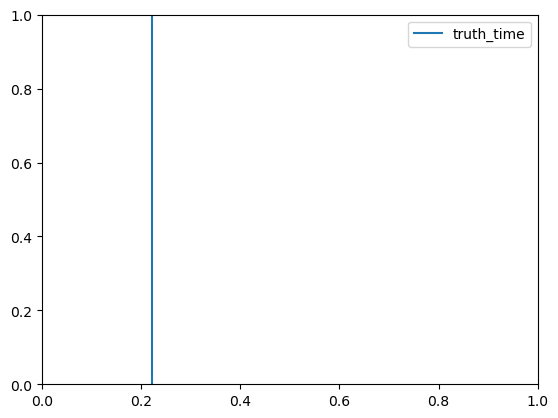

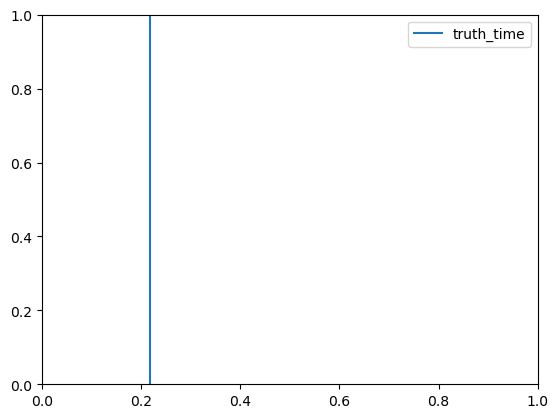

In [3]:
import matplotlib.pyplot as plt

dictionary_of_truth = {}
dictionary_of_all_problems = {}
dictionary_of_plots_ub = {}
dictionary_of_plots_lb = {}
dictionary_of_plots_truth = {}

filename = "output/table.json"
figname = "output/figure"

for key in PROBLEMS.keys():
    if key == "belgian_model":
        continue
    dictionary_of_all_problems[key] = {}
    dictionary_of_truth[key] = "output/truth/"+str(key)+"/100.json"
    
    with open(dictionary_of_truth[key], "r") as truth_json:
        truth_json = json.load(truth_json)
    dictionary_of_plots_truth[key] = abs(truth_json["timing"] + truth_json["timing - fixed costs"])
    dictionary_of_truth[key] = "output/truth/"+str(key)+"/100.npz"
    dictionary_of_plots_ub[key] = {"plt_x": [], "plt_y":[], "plt_name":[]}
    dictionary_of_plots_lb[key] = {"plt_x": [], "plt_y":[], "plt_name":[]}

for input_file in snakemake.input:
    data = load_result_and_bounds(input_file)    
    dict_problem = dictionary_of_all_problems[data["problem"]]
    timing = data["timing"] + data["timing - fixed costs"]
    name = data["name"]
    error = compute_errors(PROBLEMS[data["problem"]], data, np.load(dictionary_of_truth[data["problem"]])["arr_0"])
    current_dict = {"timing": timing,
                    "error": error,
                    }
    if not np.isnan(error[0]):
        if error[2] == 1.0:
            if data["bound_type"] == "lb":
                dictionary_of_plots_lb[data["problem"]]["plt_y"].append(error[1])
                dictionary_of_plots_lb[data["problem"]]["plt_x"].append(timing)
                dictionary_of_plots_lb[data["problem"]]["plt_name"].append((data["name"], data["N"]))
            else:
                dictionary_of_plots_ub[data["problem"]]["plt_y"].append(error[1])
                dictionary_of_plots_ub[data["problem"]]["plt_x"].append(timing)
                dictionary_of_plots_ub[data["problem"]]["plt_name"].append((data["name"], data["N"]))
    
    if name not in dict_problem:
        dict_problem[name] = {data["bound_type"]: {data["N"] : current_dict}}
    else:
        current_problem = dict_problem[name]
        if data["bound_type"] not in current_problem:
            current_problem[data["bound_type"]] = {data["N"] : current_dict}
        else:
            current_N = current_problem[data["bound_type"]]
            if data["N"] in current_N:
                print("ERROR should not happen")
            else:
                current_N[data["N"]] = current_dict

with open(filename, "w") as outfile:
    json.dump(dictionary_of_all_problems, outfile, sort_keys=True, indent=4)

def plot_not_dominated(dictionary_of_plots, add_to_name="lb", truth_plot=None):
    for plot_prob in dictionary_of_plots.keys():
        plot_acc = dictionary_of_plots[plot_prob]
        plt_x, plt_y, plt_name = not_dominated_points(plot_acc["plt_x"], plot_acc["plt_y"], plot_acc["plt_name"])
        plt.figure()
        for i, j, (label_to_give, nb_bounds) in zip(plt_x, plt_y, plt_name):
            if nb_bounds == 2:
                plt.plot(i, j, ".", label=label_to_give+str(nb_bounds))
            elif nb_bounds == 6:
                plt.plot(i, j, "x", label=label_to_give+str(nb_bounds))
            else :
                plt.plot(i, j, "^", label=label_to_give+str(nb_bounds))
        if truth_plot is not None:
            plt.axvline(x = truth_plot[plot_prob], label="truth_time")
        plt.legend()
        plt.savefig(figname+"_"+plot_prob+"_"+add_to_name+".png")

plot_not_dominated(dictionary_of_plots_lb, "lb", dictionary_of_plots_truth)
plot_not_dominated(dictionary_of_plots_ub, "ub", dictionary_of_plots_truth)
